# Ham or Spam?
In this notebook, we use daproli to explore spam texts taken from: https://www.kaggle.com/team-ai/spam-text-message-classification

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [17]:
import daproli as dp

In [3]:
df = pd.read_csv('data/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's tokenize the messages and remove all stop special characters and stop words.

In [15]:
from re import sub
from nltk.corpus import stopwords

cleaner = dp.Pipeline(
    dp.Mapper(lambda m : sub('[^a-zA-Z0-9]', '', m)),
    dp.Filter(lambda m : not m.isnumeric()),
    dp.Filter(lambda m : len(m) > 1),
    dp.Filter(lambda m : m not in stopwords.words('english')),
)

tokenizer = dp.Pipeline(
    dp.Manipulator(lambda ms : ms.to_numpy().tolist()),
    dp.Mapper(lambda ms : ms.lower()),
    dp.Mapper(lambda ms : ms.split(' ')),
    dp.Mapper(lambda ms : cleaner.transform(ms)),
    verbose=1
)

messages = tokenizer.transform(df['Message'])

Let's split ham and spam messages for further analysis.

In [14]:
ham, spam = dp.Pipeline(
    dp.Combiner(lambda m, c : (m, c)),
    dp.Splitter(lambda mc : mc[1]),
    dp.Union(
        dp.Mapper(lambda mc : mc[0]),
        dp.Mapper(lambda mc : mc[0]),
    ),
).transform([messages, df['Category']])

Let's create the word distributions for both categories with words that come up at least 15% of the time.

In [9]:
from itertools import chain

distribution = dp.Pipeline(
    dp.Manipulator(chain.from_iterable),
    dp.Manipulator(list),
    dp.Manipulator(np.unique, return_counts=True),
    dp.Union(
        dp.Mapper(lambda l : l),
        dp.Manipulator(lambda c : (c - c.min()) / (c.max() - c.min())),
    ),
    dp.Manipulator(lambda lc : zip(*lc)),
    dp.Filter(lambda lc : lc[1] > .15),
    dp.Manipulator(sorted, key = lambda x : x[1]),
    dp.Manipulator(lambda lc : lc[::-1]),
    dp.Expander(lambda lc : lc),
    dp.Union(dp.Manipulator(np.array), dp.Manipulator(np.array))
)

In [10]:
ham_bins, ham_freq = distribution.transform(ham)
spam_bins, spam_freq = distribution.transform(spam)

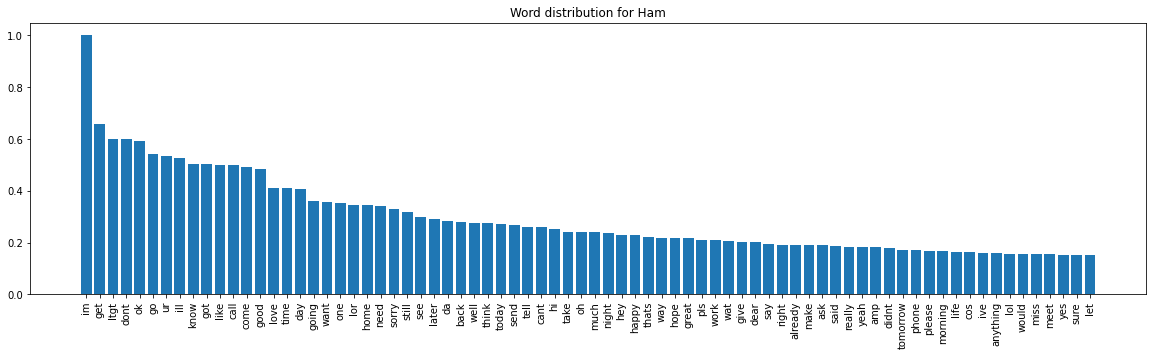

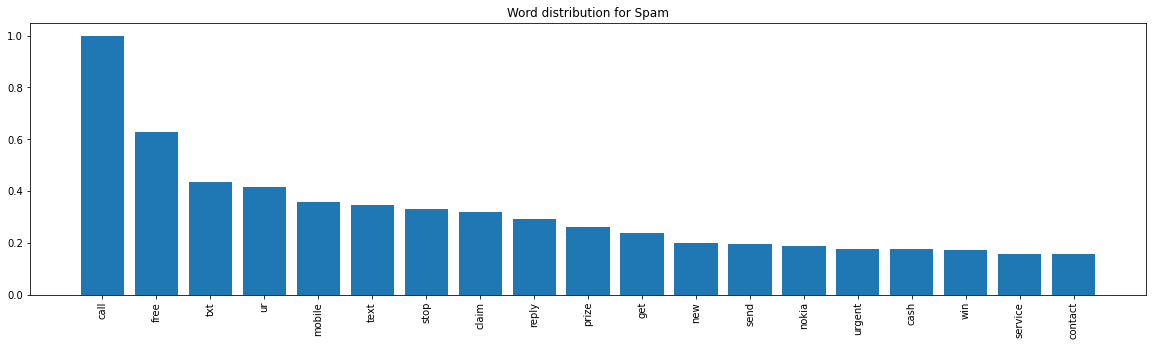

In [11]:
for cat, bins, freq in zip(['Ham', 'Spam'], [ham_bins, spam_bins], [ham_freq, spam_freq]):
    plt.figure(figsize=(20,5))
    plt.bar(np.arange(bins.shape[0]), freq)
    plt.title(f"Word distribution for {cat}")
    plt.xticks(np.arange(bins.shape[0]), bins.tolist(), rotation=90)
    plt.show()